# Demonstration of EPISTEM-x Module 
This notebook contain the implementation of the source code for each module in the EPISTEM land cover mapping framework

## Library import and earth engine initialization
If you have earth engine account you could used that to authenticate and initialize the earth engine. However, if you did not have the account, service account initialization is avaliable

In [1]:
#This code is used if the notebook is implemented in github codespace. Just remove the (#)
!python -m pip install .. --quiet

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress t

In [1]:
import ee 
import epistemx

#Option 1: Manual authenticate using personal account
#Instructions for manual authentication
epistemx.print_auth_instructions()
#uncomment the below line and follow earth engine authentication process
epistemx.authenticate_manually()

#Option 2: Autheticate using service account (json file)
service_account_path = '../auth/ee-rg2icraf-ecab9c534f91.json'
success = epistemx.initialize_with_service_account(service_account_path)

if success:
    print("Earth Engine initialized with service account successfully!")
else:
    print("Service account initialization failed. Try to authenticate earth engine manually")

#Check authentication status
status = epistemx.get_auth_status()
print(f"Initialized: {status['initialized']}")
print(f"Authenticated: {status['authenticated']}")
if status['project']:
    print(f"Project: {status['project']}")


    EARTH ENGINE AUTHENTICATION NOTES:
    
    1. Make sure you already have a google cloud project that has enable the Earth Engine API and registered to 
       commercial or non-commercial use. For more information visit: https://developers.google.com/earth-engine/guides/access 
    
    2. you can authenticate programmatically by calling: from epistemx.ee_config import authenticate_manually
       authenticate_manually()
    
    3. This will open a web browser. Sign in with your Google account that has Earth Engine access.
    
    4. Copy the authorization code from the browser and paste it in the terminal.
    
    
    For more details, visit: https://developers.google.com/earth-engine/guides/python_install
    


Service account file not found: ../auth/ee-rg2icraf-ecab9c534f91.json


Service account initialization failed. Try to authenticate earth engine manually
Initialized: True
Authenticated: True
Project: projects/ee-agilakbarfahrezi/assets/AOICImanukhulu


In [2]:
import geemap
from epistemx.data_acquisition import Reflectance_Data, Reflectance_Stats
from epistemx.helpers import get_aoi_from_gaul

## Module 1: Acquisition of Near-Cloud-Free Satellite Imagery

### System Response 1.1: Area of Interest Definition

In [3]:
#Set the country and province for the AOI using GAUL admin boundaries
aoi = get_aoi_from_gaul(country="Indonesia", province="Sumatera Selatan")
#Alternatively, used geemap_shp_to_ee to directly used shapefile in your local machine

### System Response 1.2: Search and Filter Imagery
The EPISTEM source code supports Landsat mission data, ranging from Landsat 1 to Landsat 9. For Landsat 1 - 3, the avaliable data is corrected radiance reflectance. The Landsat 5-9 used here is collection 2 surface reflectance (SR) analysis ready data.

The retrival logic used here is as follow:
1. Retrive multispectral bands (band 1 - 7) from landsat collection 2 SR data (if avaliable)
2. Retrive thermal band from landsat collection 2 TOA data 
3. Create temporal composite for each data 
4. Stacked the final two data into a earth engine image (ee.image)

In [4]:
#========== FIRST RETRIVE THE MULTISPECTRAL BAND===========
#Intialize the relfectance class data function
optical_reflectance = Reflectance_Data()
#define the start and end date for imagery collection
start = '2017-01-01'
end = '2017-12-31'
#get the image collection and corresponding statistics
landsat_data, meta = optical_reflectance.get_optical_data(aoi, start, end, optical_data='L8_SR', 
                                                           cloud_cover=40, compute_detailed_stats=False)
#create mosaic between image collection, and clip based on AOI
mosaic_landsat = landsat_data.mosaic().clip(aoi)
#Alternatively you can use temporal aggregation (ee reducer) to create mode cloudless imagery
median_landsat = landsat_data.median().clip(aoi)
#visualization parameter
l8_sr_visparam = {'min': 0,'max': 0.4,'gamma': [0.95, 1.1, 1],'bands':['NIR', 'RED', 'GREEN']}
#Add the data to the map
Map = geemap.Map()
Map.addLayer(mosaic_landsat, l8_sr_visparam, 'L8 SR Mosaic')
Map.addLayer(median_landsat, l8_sr_visparam, 'L8 SR Median')
Map.addLayer(landsat_data, l8_sr_visparam, 'L8 SR Image Collection')
# set center of the map in the area of interest
Map.centerObject(aoi, 7)

2025-11-19 11:43:13,165 - Reflectance_Data - INFO - ReflectanceData initialized.
2025-11-19 11:43:13,167 - Reflectance_Data - INFO - Starting data fetch for Landsat 8 Operational Land Imager Surface Reflectance
2025-11-19 11:43:13,168 - Reflectance_Data - INFO - Date range: 2017-01-01 to 2017-12-31
2025-11-19 11:43:13,169 - Reflectance_Data - INFO - Cloud cover threshold: 40%
2025-11-19 11:43:13,170 - Reflectance_Data - INFO - detailed statistics will not be computed
2025-11-19 11:43:13,171 - Reflectance_Stats - INFO - Reflectance Stats initialized.
2025-11-19 11:43:13,172 - Reflectance_Data - INFO - Filtered collection created (use compute_detailed_stats=True for more information)


In [5]:
#retive thermal bands from TOA
thermal_bands, thermal_stats = optical_reflectance.get_thermal_bands(aoi, start, end, cloud_cover=40, compute_detailed_stats=False)
median_thermal = thermal_bands.median().clip(aoi)
thermal_vis = {
    'min': 286,
    'max': 300,
    'gammma': 0.4
}
#stacked all landsat bands
stacked_landsat = median_landsat.addBands(median_thermal)
#visualize the thermal bands and multispectral bands
Map.addLayer(median_thermal, thermal_vis, "Thermal Bands")
Map

2025-11-19 11:43:18,641 - Reflectance_Stats - INFO - Reflectance Stats initialized.
2025-11-19 11:43:18,642 - Reflectance_Data - INFO - Starting thermal data fetch for Landsat 8 Top-of-atmosphere reflectance
2025-11-19 11:43:18,643 - Reflectance_Data - INFO - Date range: 2017-01-01 to 2017-12-31
2025-11-19 11:43:18,644 - Reflectance_Data - INFO - Cloud cover threshold: 40%
2025-11-19 11:43:18,645 - Reflectance_Data - INFO - Fast mode enabled - detailed statistics will not be computed
2025-11-19 11:43:18,646 - Reflectance_Data - INFO - Filtered collection created (use compute_detailed_stats=True for detailed info)


Map(center=[-3.2210694545062024, 104.16355582426586], controls=(WidgetControl(options=['position', 'transparen…

### Image retrival report (optional)

In [6]:
#intialize the statistic class
stats = Reflectance_Stats()
#get the retrival report and automatically print them
retrival_report = stats.get_collection_statistics(landsat_data, print_report=True)

2025-11-19 11:43:36,309 - Reflectance_Stats - INFO - Reflectance Stats initialized.


           Landsat Data Collection Retrival Report
Total Images Found: 53
Date Range: 2017-01-13 to 2017-12-17
Unique WRS Tiles: 10

Scene Cloud Cover Statistics:
------------------------------
Average Cloud Cover: 26.8%
Minimum Cloud Cover: 2.9%
Maximum Cloud Cover: 40.0%

WRS Path/Row Tiles:
------------------------------
Path 123/Row 062
Path 123/Row 063
Path 124/Row 061
Path 124/Row 062
Path 124/Row 063
Path 124/Row 064
Path 125/Row 061
Path 125/Row 062
Path 125/Row 063
Path 126/Row 062

Available Acqusition Date:
------------------------------
Date range: 2017-01-13 to 2017-12-17
(53 total acquisition dates)

Scene IDs (first 10):
------------------------------
• LC08_123062_20170405
• LC08_123062_20170421
• LC08_123062_20170726
• LC08_123062_20170912
• LC08_123062_20171014
• LC08_123062_20171217
• LC08_123063_20170710
• LC08_123063_20170827
• LC08_123063_20170912
• LC08_123063_20171030
... and 43 more scenes



### System Response 1.3: Imagery Download

In [ ]:
export_task = ee.batch.Export.image.toDrive(
    image=stacked_landsat,
    description='Landsat_Median_composite_2017_Sumsel',
    folder='Earth Engine',
    fileNamePrefix='Landsat_Median_composite_2017_Sumsel',
    scale=30,
    region=aoi,  # or aoi.geometry()
    maxPixels=1e13
)
export_task.start()
import time

while export_task.active():
    print('Exporting... (status: {})'.format(export_task.status()['state']))
    time.sleep(10)

print('Export complete (status: {})'.format(export_task.status()['state']))

## Module 2:  Land-cover classification Scheme
Three approach are provided to handle classification scheme:
1. Upload a csv file 
2. Manual input the classification scheme
3. Use default classification scheme (RESTORE+ project)

### Import the module

In [7]:
from epistemx.classification_scheme import LULC_Scheme_Manager
#Initialize the LULC Scheme Manager
manager = LULC_Scheme_Manager()
print("Land Cover Classification Scheme Manager initialized!")
print(f"Current class count: {manager.get_class_count()}")
#Temporary function to display the classiifcation scheme in notebook
#Display current classification scheme
def display_classification_scheme(manager):
    """Display the current classification scheme in a readable format"""
    if not manager.has_classes():
        print("No classes defined yet.")
        return
    
    print("\n=== Current Classification Scheme ===")
    df = manager.get_dataframe()
    print(df.to_string(index=False))
    
    return df

# Display the scheme
df = display_classification_scheme(manager)

Land Cover Classification Scheme Manager initialized!
Current class count: 0
No classes defined yet.


### System Response 2.1a: Upload Classification Scheme

In [8]:
import pandas as pd
#Reset manager for CSV upload example
manager = LULC_Scheme_Manager()
#path to csv 
csv_path = "../test_data/Example_Classification_scheme.csv"

print("=== CSV Upload Process ===")

# Load the CSV
df = pd.read_csv(csv_path, sep=None, engine="python")
print("Loaded CSV:")
print(df)

# Auto-detect columns
id_col, name_col, color_col = manager.auto_detect_csv_columns(df)
print(f"\nAuto-detected columns:")
print(f"ID column: {id_col}")
print(f"Name column: {name_col}")
print(f"Color column: {color_col}")

=== CSV Upload Process ===
Loaded CSV:
    ﻿No                       Class_name  Class_id
0     1               Rubber monoculture        15
1     2                       Settlement        16
2     3             Oil palm monoculture        11
3     4                       Water Body        19
4     5                Acacia plantation         1
5     6                       Rice Field        13
6     7                     Mixed Garden        10
7     8                Rubber agroforest        14
8     9   Logged Over Forest Low Density         8
9    10                            Shrub        17
10   11                            Grass         6
11   12         Logged over swamp forest         9
12   13  Logged over forest-high density         7
13   14                Coffee Agroforest         5
14   15              Coconut monoculture         4
15   16                      Other Crops        12
16   17                     Cleared Land         3
17   18                   Tea plantation   

In [9]:
# Process CSV upload
success, message = manager.process_csv_upload(df, id_col, name_col, color_col)
if success:
    print(f"✅ {message}")
    
    # Finalize the upload
    success, message = manager.finalize_csv_upload()
    if success:
        print(f"✅ {message}")
    else:
        print(f"❌ {message}")
else:
    print(f"❌ {message}")

# Display the loaded scheme
display_classification_scheme(manager)

✅ Successfully loaded 19 classes from CSV with auto-generated colors
✅ Classification scheme created with 19 classes

=== Current Classification Scheme ===
 ID                Land Cover Class Color Palette
  1               Acacia plantation       #FFEAA7
  2                            Cane       #AED6F1
  3                    Cleared Land       #F9E79F
  4             Coconut monoculture       #D7BDE2
  5               Coffee Agroforest       #85C1E9
  6                           Grass       #F8C471
  7 Logged over forest-high density       #F1948A
  8  Logged Over Forest Low Density       #BB8FCE
  9        Logged over swamp forest       #82E0AA
 10                    Mixed Garden       #98D8C8
 11            Oil palm monoculture       #45B7D1
 12                     Other Crops       #A3E4D7
 13                      Rice Field       #DDA0DD
 14               Rubber agroforest       #F7DC6F
 15              Rubber monoculture       #FF6B6B
 16                      Settlement       #4

,ID,Land Cover Class,Color Palette
0,1,Acacia plantation,#FFEAA7
1,2,Cane,#AED6F1
2,3,Cleared Land,#F9E79F
3,4,Coconut monoculture,#D7BDE2
4,5,Coffee Agroforest,#85C1E9
5,6,Grass,#F8C471
6,7,Logged over forest-high density,#F1948A
7,8,Logged Over Forest Low Density,#BB8FCE
8,9,Logged over swamp forest,#82E0AA
9,10,Mixed Garden,#98D8C8


### System Response 2.1b: Manual Scheme Definition

In [ ]:
#Reset manager for manual input example
manager = LULC_Scheme_Manager()
#Manually add the class
print("=== Manual Class Addition ===")

#Example of class to add
classes_to_add = [
    (1, "Hutan Lahan Kering", "#0E6D0E"),
    (2, "Pertanian Lahan Kering", "#E8F800"),
    (3, "Permukiman", "#F81D00"),
    (4, "Badan Air", "#1512F3"),
    (5, "Pertanian Lahan Basah", "#")
]

for class_id, class_name, color_code in classes_to_add:
    success, message = manager.add_class(class_id, class_name, color_code)
    if success:
        print(f"✅ {message}")
    else:
        print(f"❌ {message}")

print(f"\nTotal classes: {manager.get_class_count()}")

In [ ]:
# Example: Edit an existing class
print("=== Editing a Class ===")

# Edit the first class (index 0)
class_to_edit = manager.edit_class(0)
if class_to_edit:
    print(f"Editing class: {class_to_edit}")
    
    # Update the class with new information
    success, message = manager.add_class(1, "HUtan Lahan Rendah", "#004D00")
    if success:
        print(f"✅ {message}")
    else:
        print(f"❌ {message}")

# Display updated scheme
display_classification_scheme(manager)

### System Response 2.1c: Template Classification Scheme

In [ ]:
# Reset manager for default scheme example
manager = LULC_Scheme_Manager()

print("=== Available Default Schemes ===")
default_schemes = manager.get_default_schemes()

for scheme_name, classes in default_schemes.items():
    print(f"\n{scheme_name}: {len(classes)} classes")
    for class_data in classes:
        print(f"  - ID {class_data['ID']}: {class_data['Class Name']} ({class_data['Color Code']})")

In [8]:
# Load the RESTORE+ default scheme
scheme_name = "RESTORE+ Project"
success, message = manager.load_default_scheme(scheme_name)

if success:
    print(f"✅ {message}")
else:
    print(f"❌ {message}")

# Display the loaded scheme
display_classification_scheme(manager)

✅ Loaded RESTORE+ Project with 17 classes

=== Current Classification Scheme ===
 ID            Land Cover Class Color Palette
  1 Undisturbed dry-land forest       #006400
  2 Logged-over dry-land forest       #228B22
  3        Undisturbed mangrove       #4169E1
  4        Logged-over mangrove       #87CEEB
  5    Undisturbed swamp forest       #2E8B57
  6    Logged-over swamp forest       #8FBC8F
  7                Agroforestry       #9ACD32
  8           Plantation forest       #32CD32
  9          Rubber monoculture       #8B4513
 10        Oil palm monoculture       #FF8C00
 11           Other monoculture       #DAA520
 12               Grass/savanna       #ADFF2F
 13                       Shrub       #90EE90
 14                    Cropland       #FFFF00
 15                  Settlement       #FF0000
 16                Cleared land       #D2B48C
 17                   Waterbody       #0000FF


,ID,Land Cover Class,Color Palette
0,1,Undisturbed dry-land forest,#006400
1,2,Logged-over dry-land forest,#228B22
2,3,Undisturbed mangrove,#4169E1
3,4,Logged-over mangrove,#87CEEB
4,5,Undisturbed swamp forest,#2E8B57
5,6,Logged-over swamp forest,#8FBC8F
6,7,Agroforestry,#9ACD32
7,8,Plantation forest,#32CD32
8,9,Rubber monoculture,#8B4513
9,10,Oil palm monoculture,#FF8C00


### System Response 2.2: Download classification scheme

In [9]:
print("=== Export Classification Scheme ===")
#Convert the selected  classification scheme manager to dataframe
classification_df = manager.get_dataframe()
print("Classification DataFrame:")
print(classification_df)
#Save the file
output_path = '../Selected_LC_Classification_Scheme.csv'
classification_df.to_csv(output_path, index=False)
print(f"\n✅ Classification scheme saved to: {output_path}")

=== Export Classification Scheme ===
Classification DataFrame:
    ID             Land Cover Class Color Palette
0    1  Undisturbed dry-land forest       #006400
1    2  Logged-over dry-land forest       #228B22
2    3         Undisturbed mangrove       #4169E1
3    4         Logged-over mangrove       #87CEEB
4    5     Undisturbed swamp forest       #2E8B57
5    6     Logged-over swamp forest       #8FBC8F
6    7                 Agroforestry       #9ACD32
7    8            Plantation forest       #32CD32
8    9           Rubber monoculture       #8B4513
9   10         Oil palm monoculture       #FF8C00
10  11            Other monoculture       #DAA520
11  12                Grass/savanna       #ADFF2F
12  13                        Shrub       #90EE90
13  14                     Cropland       #FFFF00
14  15                   Settlement       #FF0000
15  16                 Cleared land       #D2B48C
16  17                    Waterbody       #0000FF

✅ Classification scheme saved to: ..

# Module 3: Generate Region Of Interest
Three methods to generate ROI are supported in EPISTEM platform:
1. **Upload Training Data** - Upload your own shapefile
2. **On-screen Sampling** - Create samples using interactive map
3. **Default Reference Data** - Use Epistem's default training data

## Library Import and Setup

## System Response 3.1 Prerequisite Check

In [10]:
print("=== Checking Prerequisites ===")
#Load from previous module
#From Module 1 - AOI data
try:
    AOI = aoi
    print("✅ AOI from Module 1 is available")
    aoi_available = True
except:
    print("❌ AOI data not available, please run Module 1 first")
    aoi_available = False

#From Module 2 - Classification scheme
try:
    
    # For demonstration, create sample classification scheme
    LULCTable = classification_df
    print("✅ Classification scheme from Module 2 is available")
    print(f"   - Number of classes: {len(LULCTable)}")
    scheme_available = True
except:
    print("❌ Classification scheme not available, please run Module 2 first")
    scheme_available = False

if aoi_available and scheme_available:
    print("\n✅ All prerequisites met! You can proceed with training data collection.")
else:
    print("\n❌ Prerequisites not met. Please complete previous modules first.")

=== Checking Prerequisites ===
✅ AOI from Module 1 is available
✅ Classification scheme from Module 2 is available
   - Number of classes: 17

✅ All prerequisites met! You can proceed with training data collection.


## System Response 3.2 ROI Upload and content Verification

In [11]:
# Modul 3a 
# Import modules and functions
import ee
import pandas as pd
from epistemx.sample_data import SyncTrainData, SplitTrainData, LULCSamplingTool

In [ ]:
# ----- Data Input -----
# 1. Decision to upload data
UploadTrainData = True # set as 'true' to upload your own training data shapefile
# set as 'false' to either add train data by sampling on screen or use default training data

# 2. Training data file path (if UploadTrainData is true)
TrainVectPath  = '../test_data/Training_Sumsel_Data.shp'
TrainField = 'ID' 
        # Load and process training data
TrainDataDict = SyncTrainData.LoadTrainData(
            landcover_df=LULCTable,
            aoi_geometry=AOI,
            training_shp_path=TrainVectPath
        )

In [18]:
# ----- System response 3.2.a -----
# Set class field
TrainDataDict = SyncTrainData.SetClassField(TrainDataDict, TrainField)

# Validate classes
TrainDataDict = SyncTrainData.ValidClass(TrainDataDict, 1)

    # Check sample sufficiency
TrainDataDict = SyncTrainData.CheckSufficiency(TrainDataDict, min_samples=20)

    # Filter by AOI
TrainDataDict = SyncTrainData.FilterTrainAoi(TrainDataDict)

    # Create training data table
table_df, total_samples, insufficient_df = SyncTrainData.TrainDataRaw(
    training_data=TrainDataDict.get('training_data'),
    landcover_df=TrainDataDict.get('landcover_df'),
    class_field=TrainDataDict.get('class_field'))

#Summary result
vr = TrainDataDict.get('validation_results', {})

print("=" * 70)
print("TRAINING DATA SUMMARY")
print("=" * 70)
print(f"Total training points loaded     : {vr.get('total_points', 'N/A')}")
print(f"Points after class filtering     : {vr.get('points_after_class_filter', 'N/A')}")
print(f"Valid points (inside AOI)        : {vr.get('valid_points', 'N/A')}")
print(f"Invalid classes found            : {len(vr.get('invalid_classes', []))}")
print(f"Points outside AOI               : {len(vr.get('outside_aoi', []))}")
print("=" * 70)

    # --- Display the main table ---
if table_df is not None and not table_df.empty:
        display_df = table_df.copy()
        if 'Percentage' in display_df.columns:
            display_df['Percentage'] = display_df['Percentage'].apply(
                lambda x: f"{x:.2f}%" if isinstance(x, (int, float)) else x
            )
        display(display_df)
else:
        print("No valid training data available to display.")

INFO: Added 'Land Cover Class' column to training data
INFO: Validation complete. 1622 valid training points remain.
TRAINING DATA SUMMARY
Total training points loaded     : 1622
Points after class filtering     : 1622
Valid points (inside AOI)        : 1622
Invalid classes found            : 0
Points outside AOI               : 0


,ID,LULC_class,Sample_Count,Percentage,Status
0,1,Acacia plantation,29,1.79%,Sufficient
1,2,Cane,22,1.36%,Sufficient
2,3,Cleared Land,14,0.86%,Insufficient
3,4,Coconut monoculture,4,0.25%,Insufficient
4,5,Coffee Agroforest,31,1.91%,Sufficient
5,6,Grass,21,1.29%,Sufficient
6,7,Logged over forest-high density,3,0.18%,Insufficient
7,8,Logged Over Forest Low Density,33,2.03%,Sufficient
8,9,Logged over swamp forest,13,0.80%,Insufficient
9,10,Mixed Garden,125,7.71%,Sufficient


## System Response 3.2 Default ROI

In [ ]:
print(" Loading default reference training data...")
TrainEePath = 'projects/ee-rg2icraf/assets/Indonesia_lulc_Sample'
TrainField = 'kelas'
    
try:
    print("Loading reference training data from Earth Engine...")
        
        # Load training data
    TrainDataDict = SyncTrainData.LoadTrainData(
            landcover_df=LULCTable,
            aoi_geometry=AOI,
            training_ee_path=TrainEePath
        )
        
    print("Processing and validating reference data...")
        
        # Set class field
    TrainDataDict = SyncTrainData.SetClassField(TrainDataDict, TrainField)
        
        # Validate classes
    TrainDataDict = SyncTrainData.ValidClass(TrainDataDict)
        
        # Check sufficiency
    TrainDataDict = SyncTrainData.CheckSufficiency(TrainDataDict, min_samples=20)
        
        # Filter by AOI
    TrainDataDict = SyncTrainData.FilterTrainAoi(TrainDataDict)
        
        # Create summary table
    table_df, total_samples, insufficient_df = SyncTrainData.TrainDataRaw(
            training_data=TrainDataDict.get('training_data'),
            landcover_df=TrainDataDict.get('landcover_df'),
            class_field=TrainDataDict.get('class_field')
        )
        
    print("✅ Reference training data loaded and processed successfully!")
    print(f"Total samples: {total_samples}")
        
        # Display summary table
    display(table_df)
        
        # Store final training data
    TrainDataFinal = TrainDataDict.get('training_data')
        
        # Show validation results
    vr = TrainDataDict.get('validation_results', {})
    print(f"\nValidation Results:")
    print(f"- Total points loaded: {vr.get('total_points', 'N/A')}")
    print(f"- Points after class filter: {vr.get('points_after_class_filter', 'N/A')}")
    print(f"- Valid points (within AOI): {vr.get('valid_points', 'N/A')}")
    print(f"- Invalid classes: {len(vr.get('invalid_classes', []))}")
        
except Exception as e:
        print(f"❌ Error loading reference data: {e}")
        TrainDataFinal = None

# Module 4: Region of Interest Separability Analysis

## Library Import and Setup

In [ ]:
#Import the sample quality functions
from epistemx.sample_data_quality import sample_quality, spectral_plotter
#if there's error in the import, uncomment the below line to install the PyCRS package
#!pip install PyCRS

## System Response 4.1 Computing Separability Analysis

In [22]:
roi_path = '../test_data/Training_Sumsel_Data.shp'
labeled_roi = geemap.shp_to_ee('../test_data/Training_Sumsel_Data.shp')
# labeled_roi = geemap.gdf_to_ee(TrainDataFinal)

#Conduct the analysis
analyzer = sample_quality(training_data=labeled_roi, 
    image= stacked_landsat, 
    class_property='ID',           # Column with numeric IDs (1, 2, 3, etc.)
    region= aoi,
    class_name_property='LC_Name'          # Column with names ('Forest', 'Urban', 'Water', etc.)
)
# Extract spectral values
pixel_extract = analyzer.extract_spectral_values(scale=30, max_pixels_per_class=5000)
samples_statistic = analyzer.sample_stats()
sample_df = analyzer.get_sample_stats_df()
display(sample_df)
#Sample statistic

Extracted spectral values for 1619 samples across 19 classes


,ID,LC_Name,Sample_Count,Proportion,Percentage
0,1,Acacia plantation,29,0.0179,1.79
1,10,Mixed Garden,125,0.0771,7.71
2,11,Oil palm monoculture,241,0.1486,14.86
3,12,Other Crops,14,0.0086,0.86
4,13,Rice Field,67,0.0413,4.13
5,14,Rubber agroforest,24,0.0148,1.48
6,15,Rubber monoculture,724,0.4464,44.64
7,16,Settlement,194,0.1196,11.96
8,17,Shrub,11,0.0068,0.68
9,18,Tea plantation,5,0.0031,0.31


In [23]:
#Sample statistic (pixel value extracted from the imagery)
pixel_stats = analyzer.sample_pixel_stats(pixel_extract)
pixel_stats_df = analyzer.get_sample_pixel_stats_df(pixel_extract)
display(pixel_stats_df)

,ID,LC_Name,Band,Mean,Std,Min,Max,Median,Count
0,1,Acacia plantation,AEROSOL,0.03,0.02,-0.04,0.05,0.03,29
1,1,Acacia plantation,BLUE,0.03,0.02,-0.03,0.07,0.03,29
2,1,Acacia plantation,GREEN,0.07,0.02,0.04,0.11,0.07,29
3,1,Acacia plantation,NIR,0.32,0.05,0.23,0.44,0.33,29
4,1,Acacia plantation,RED,0.07,0.03,0.02,0.15,0.07,29
...,...,...,...,...,...,...,...,...,...
147,19,Water Body,NIR,0.20,0.09,0.07,0.38,0.20,47
148,19,Water Body,RED,0.08,0.02,0.03,0.11,0.07,47
149,19,Water Body,SWIR1,0.13,0.05,0.02,0.23,0.14,47
150,19,Water Body,SWIR2,0.08,0.03,0.02,0.17,0.08,47


In [24]:
#Perform separability Analysis (iether using Transformed Divergence or Jeffries Matutista )
separability_analysis = analyzer.get_separability_df(pixel_extract, method='TD')
display(separability_analysis)

,Class1_ID,Class1_Name,Class2_ID,Class2_Name,TD_Distance,Separability_Level
0,15,Rubber monoculture,11,Oil palm monoculture,0.609,Class confusions
1,11,Oil palm monoculture,15,Rubber monoculture,0.609,Class confusions
2,19,Water Body,13,Rice Field,0.718,Class confusions
3,13,Rice Field,19,Water Body,0.718,Class confusions
4,10,Mixed Garden,15,Rubber monoculture,0.728,Class confusions
...,...,...,...,...,...,...
337,18,Tea plantation,13,Rice Field,2.000,Good Separability
338,18,Tea plantation,1,Acacia plantation,2.000,Good Separability
339,16,Settlement,18,Tea plantation,2.000,Good Separability
340,16,Settlement,4,Coconut monoculture,2.000,Good Separability


In [25]:
#Get the lowest separability
lowest_sep = analyzer.lowest_separability(pixel_extract)
display(lowest_sep)

,Class1_ID,Class1_Name,Class2_ID,Class2_Name,JM_Distance,Separability_Level,Interpretation
0,15,Rubber monoculture,11,Oil palm monoculture,0.568,Class confusions,Class confusions
1,11,Oil palm monoculture,15,Rubber monoculture,0.568,Class confusions,Class confusions
2,13,Rice Field,19,Water Body,0.620,Class confusions,Class confusions
3,19,Water Body,13,Rice Field,0.620,Class confusions,Class confusions
4,15,Rubber monoculture,10,Mixed Garden,0.639,Class confusions,Class confusions
5,10,Mixed Garden,15,Rubber monoculture,0.639,Class confusions,Class confusions
6,8,Logged Over Forest Low Density,10,Mixed Garden,0.646,Class confusions,Class confusions
7,10,Mixed Garden,8,Logged Over Forest Low Density,0.646,Class confusions,Class confusions
8,13,Rice Field,10,Mixed Garden,0.714,Class confusions,Class confusions
9,10,Mixed Garden,13,Rice Field,0.714,Class confusions,Class confusions


In [26]:
# Overall separability summary
sep_summary = analyzer.sum_separability(pixel_extract)
print("Overall Separability Statistics:")
display(sep_summary)

Overall Separability Statistics:


,Total Pairs,Good Separability Pairs,Weak Separability Pairs,Worst Separability Pairs
0,342,108,202,32


## System Response 4.2 Sample Visualization

In [27]:
#Box plot to detect outlier
ploter = spectral_plotter(analyzer)
box = ploter.plot_boxplot(pixel_extract)
for fig in box:
    fig.show()

In [ ]:
#static scatter plot
stat_plot = ploter.static_scatter_plot(pixel_extract, x_band='NIR', y_band='RED', add_ellipse=True)

In [ ]:
#3D scatter plot
multi_d_scater = ploter.scatter_plot_3d(pixel_extract)
multi_d_scater

# Module 6: Land Cover Classification

## Library Import

In [13]:
from epistemx.classification import FeatureExtraction, Generate_LULC
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## System Response 6.2 Classification

In [ ]:
#Perform Training Test Split
features = FeatureExtraction()
strafied_train, stratified_test = features.stratified_split(labeled_roi, stacked_landsat, 
                            class_prop='ID', train_ratio=0.5)
classifier = Generate_LULC()
print("Performing Classification...")
#Multiclass hard classification
classification_map, trained_model = classifier.hard_classification(strafied_train, class_property='ID', image=stacked_landsat,
                                                          ntrees=300, min_leaf=2, return_model=True)
# Evaluate model performance
print("Evaluating model performance...")

try:
    accuracy_metrics = classifier.evaluate_model(
        trained_model=trained_model,
        test_data=stratified_test,
        class_property='ID'
    )
    
    print("✓ Model evaluation completed")
    
except Exception as e:
    print(f"❌ Error in model evaluation: {e}")                                                    


Stratified Random Split Training Pixel Size: 814
Stratified Random Split Testing Pixel Size: 808
Performing Classification...
Evaluating model performance...
✓ Model evaluation completed


## System Response 6.3 Model Evaluation

In [30]:
# Display accuracy results
print("=== Model Performance Summary ===")
print(f"Overall Accuracy: {accuracy_metrics['overall_accuracy']:.4f} ({accuracy_metrics['overall_accuracy']*100:.2f}%)")
print(f"Kappa Coefficient: {accuracy_metrics['kappa']:.4f}")
print(f"Overall G-Mean: {accuracy_metrics['overall_gmean']:.4f}")

print("\n=== Per-Class Metrics ===")
#Class Dataframe
metrics_df = pd.DataFrame({
    'Precision': accuracy_metrics['precision'],
    'Recall': accuracy_metrics['recall'],
    'F1-Score': accuracy_metrics['f1_scores'],
    'G-Mean': accuracy_metrics['gmean_per_class']
})

# Round to 4 decimal places
metrics_df = metrics_df.round(4)

display(metrics_df)

=== Model Performance Summary ===
Overall Accuracy: 0.5353 (53.53%)
Kappa Coefficient: 0.3073
Overall G-Mean: 0.3817

=== Per-Class Metrics ===


,Precision,Recall,F1-Score,G-Mean
0,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000
5,0.2500,0.3077,0.2759,0.2774
6,0.0000,0.0000,0.0000,0.0000
7,0.0000,0.0000,0.0000,0.0000
8,0.0000,0.0000,0.0000,0.0000
9,0.0000,0.0000,0.0000,0.0000


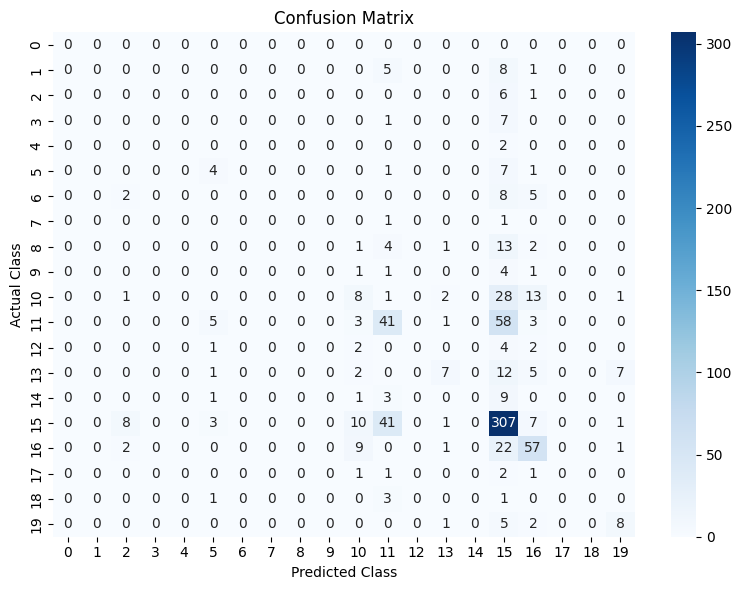

In [31]:
# Visualize confusion matrix
confusion_matrix = np.array(accuracy_metrics['confusion_matrix'])
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
plt.show()

In [ ]:
# Get feature importance
print("Analyzing feature importance...")

try:
    importance_df = classifier.get_feature_importance(trained_model)
    print("✓ Feature importance analysis completed")
    
    display(importance_df)
    
except Exception as e:
    print(f"❌ Error in feature importance analysis: {e}")
# Visualize feature importance
plt.figure(figsize=(10, 6))

# Create bar plot
bars = plt.bar(importance_df['Band'], importance_df['Importance (%)'])

# Add value labels on bars
for bar, value in zip(bars, importance_df['Importance (%)']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{value:.1f}%', ha='center', va='bottom')

plt.title('Feature Importance by Spectral Band')
plt.xlabel('Landsat 8 Bands')
plt.ylabel('Importance (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Visualization

In [32]:
# === Load Classification Scheme ===
scheme = pd.read_csv("../Selected_LC_Classification_Scheme.csv", sep=None, engine="python")
classes = [str(x).strip() for x in scheme["Land Cover Class"].tolist()]
palette = [str(x).strip() for x in scheme["Color Palette"].tolist()]
ids = scheme["ID"].tolist()
legend_dict = dict(zip(classes, palette))

# === Visualization Parameters ===
vis_params = {
    "min": min(ids),
    "max": max(ids),
    "palette": palette
}

# === Create geemap Map ===
Map = geemap.Map() 
Map.centerObject(aoi, 7)
Map.addLayer(classification_map, vis_params, "LULC Classification")

# # === Add Legend ===
Map.add_legend(
    title="Land Cover Classification", 
    legend_dict=legend_dict
    )

# Display
Map


Map(center=[-3.2210694545062024, 104.16355582426586], controls=(WidgetControl(options=['position', 'transparen…

# Module 7: Thematic Accuracy Assessment

## System Response 7.3 Thematic Accuracy Assessment

In [ ]:
from epistemx.accuracy import Thematic_Accuracy_Assessment
#Initialize the accuracy assessment class
accuracy_assessor = Thematic_Accuracy_Assessment()
print("✓ Thematic Accuracy Assessment class initialized")
print(f"Supported metrics: {accuracy_assessor.supported_metrics}")

✓ Thematic Accuracy Assessment class initialized
Supported metrics: ['overall_accuracy', 'kappa', 'producer_accuracy', 'user_accuracy', 'f1_scores', 'confusion_matrix']


In [34]:
validation_data = geemap.shp_to_ee("../test_data/Evaluation_Sumsel_data.shp") 

# === 2. Create Assessment Object ===
assessor = Thematic_Accuracy_Assessment()

# === 3. Run Accuracy Assessment ===
success, results = assessor.run_accuracy_assessment(
    lcmap=classification_map,
    validation_data=validation_data,
    class_property='LULC_ID',   #Validation ID column
    scale=30
)

# === 4. Display Results ===
if success:
    print("=== Thematic Accuracy Results ===")
    summary = assessor.format_accuracy_summary(results)
    print("Overall Accuracy :", summary['overall_accuracy'])
    print("Kappa Coefficient:", summary['kappa'])
    print("95% CI          :", summary['confidence_interval'])
    print("Samples Used     :", summary['sample_size'])
else:
    print("Error:", results["error"])


2025-10-28 06:52:50,205 - epistemx.module_7 - INFO - Starting accuracy assessment...
2025-10-28 06:53:30,200 - epistemx.module_7 - INFO - Accuracy assessment completed successfully


=== Thematic Accuracy Results ===
Overall Accuracy : 53.07%
Kappa Coefficient: 0.310
95% CI          : 50.09% - 56.05%
Samples Used     : 1076
